In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from joblib import dump, load

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style="whitegrid")

# Sklearn imports
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# old classification metrics
from sklearn.metrics import ( classification_report, confusion_matrix, 
                             precision_score, accuracy_score, 
                             precision_recall_fscore_support )
# new classification metrics
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score


sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2})
#plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams.update({'font.size': 22})

In [2]:
def sort_creator(key=None,reverse=False,cmp=None):
    '''
        Create a custom sort function for a dataframe
        https://stackoverflow.com/questions/13838405/custom-sorting-in-pandas-dataframe
    '''
    def sorter(series):
        series_list = list(series)
        return [series_list.index(i) 
           for i in sorted(series_list,key=key,reverse=reverse,cmp=cmp)]
    return sorter

In [3]:
def get_metrics(confusion_matrix_file_name):
    '''
        read a confusion matrix from a file, and calculate some metrics
        input: a pd.DataFrame representing a confusion matrix
        output: a pd.DataFrame containing the metrics
    '''
    confusion_matrix = pd.read_csv(confusion_matrix_file_name)
    
    if 'Unnamed: 0' in confusion_matrix.columns:
        confusion_matrix.drop(columns=['Unnamed: 0'], inplace=True)
    
    confusion_matrix = confusion_matrix.values
    metrics = {}
    
    FP = metrics['False Positive'] = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = metrics['False Negative'] = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = metrics['True Positive'] = np.diag(confusion_matrix)
    TN = metrics['True Negative'] = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    metrics['True Positive Rate'] = TP/(TP+FN)
    # Specificity or true negative rate
    metrics['True Negative Rate'] = TN/(TN+FP) 
    # Precision or positive predictive value
    metrics['Precision'] = TP/(TP+FP)
    # Fall out or false positive rate ##########
    metrics['False Positive Rate (FAR)'] = FP/(FP+TN)
    # False negative rate ############
    metrics['False Negative Rate (FRR)'] = FN/(TP+FN)
    # Overall accuracy
    metrics['Overall Accuracy'] = (TP+TN)/(TP+FP+FN+TN)
    
    step = confusion_matrix_file_name.split('.')[0][-1]
    if step == "4":
        step = 'DETECT'
    else:
        step = f"Scenario {step}"
            
    metrics['Step'] = step
    
    #for metric, values in metrics.items():
    #print(f'{metric} has {len(values)} lines\n')
    
    metrics_df = pd.DataFrame(metrics)

    return metrics_df

In [4]:
metrics_step_1 = get_metrics('confusion_matrix_1.csv')
metrics_step_2 = get_metrics('confusion_matrix_2.csv')
metrics_step_3 = get_metrics('confusion_matrix_3.csv')
metrics_step_4 = get_metrics('confusion_matrix_4.csv')

/home/renato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [5]:
# plot metrics here

## False Acceptance Rate

                                  Step      
False Positive Rate (FAR)  count  DETECT        1890.000000
                                  Scenario 1    1981.000000
                                  Scenario 2    1983.000000
                                  Scenario 3    1890.000000
                           mean   DETECT           0.000033
                                  Scenario 1       0.000194
                                  Scenario 2       0.000079
                                  Scenario 3       0.000080
                           std    DETECT           0.000042
                                  Scenario 1       0.000207
                                  Scenario 2       0.000069
                                  Scenario 3       0.000071
                           min    DETECT           0.000000
                                  Scenario 1       0.000000
                                  Scenario 2       0.000000
                                  Scenario 3       0.00

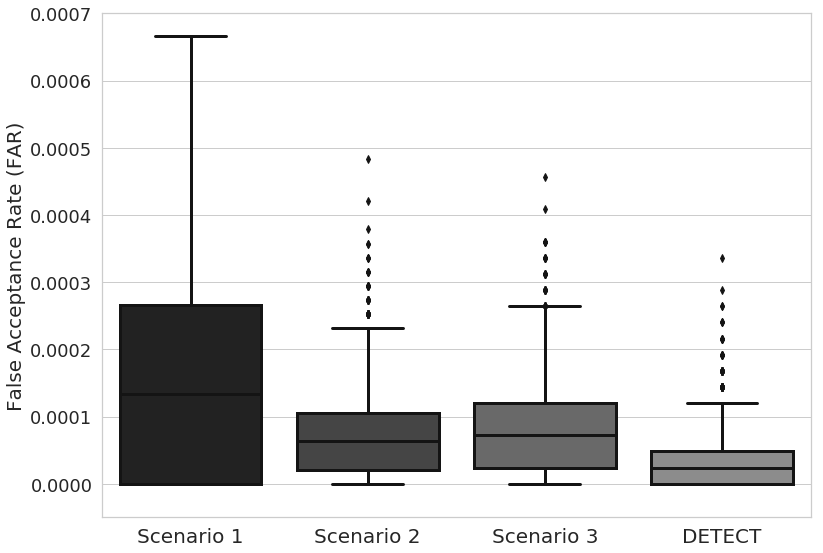

In [19]:
metric = 'False Positive Rate (FAR)'
far_columns = [metric,'Step'] 
far_data = pd.concat([
    metrics_step_1[far_columns],
    metrics_step_2[far_columns],
    metrics_step_3[far_columns],
    metrics_step_4[far_columns]
])

sns.set(rc={'figure.figsize':(12.7,9.27)})
sns.set_style("whitegrid")
plot = sns.boxplot( x=far_data["Step"], y=far_data[metric], linewidth=3, palette=sns.dark_palette("lightgrey"))

# y limit
plot.set(ylim=(-0.00005,0.0007)) # I'm hiding one Step 1 huge outlier so it does not completly mess the figure up

# labels
plot.set_ylabel("False Acceptance Rate (FAR)",fontsize=20)
plot.set_xlabel("")

# ticks
plot.set_yticklabels(['{:,.4f}'.format(x) for x in plot.get_yticks()], size=18)
plot.set_xticklabels(plot.get_xticklabels(), size = 20)

# save plot
plt.savefig('FAR_box_plot.eps')

# interquantile values
far_data.groupby("Step").describe().unstack()

## False Rejection Rate

                                  Step      
False Negative Rate (FRR)  count  DETECT        1890.000000
                                  Scenario 1    1981.000000
                                  Scenario 2    1983.000000
                                  Scenario 3    1890.000000
                           mean   DETECT           0.064003
                                  Scenario 1       0.383813
                                  Scenario 2       0.156959
                                  Scenario 3       0.153801
                           std    DETECT           0.084876
                                  Scenario 1       0.312530
                                  Scenario 2       0.134858
                                  Scenario 3       0.143330
                           min    DETECT           0.000000
                                  Scenario 1       0.000000
                                  Scenario 2       0.000000
                                  Scenario 3       0.00

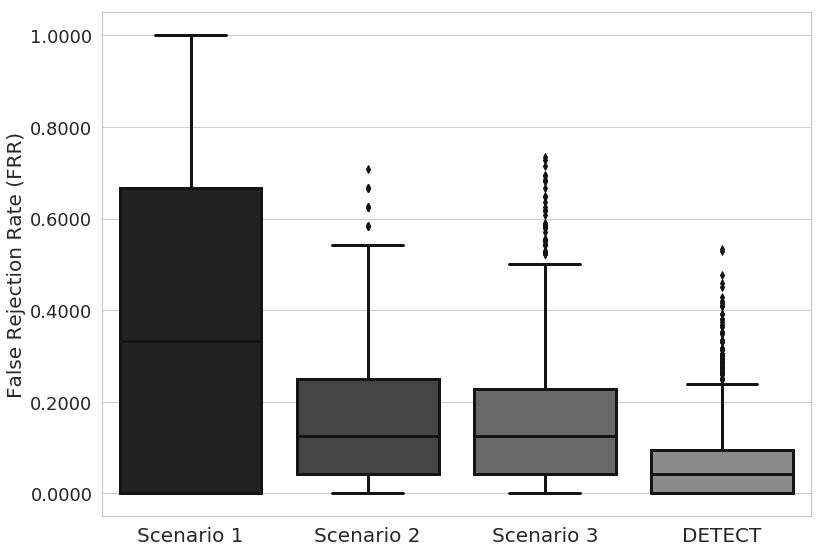

In [20]:
metric = 'False Negative Rate (FRR)'
frr_columns = [metric,'Step'] 
frr_data = pd.concat([
    metrics_step_1[frr_columns],
    metrics_step_2[frr_columns],
    metrics_step_3[frr_columns],
    metrics_step_4[frr_columns]
])

sns.set(rc={'figure.figsize':(12.7,9.27)})
sns.set_style("whitegrid")
plot = sns.boxplot( x=frr_data["Step"], y=frr_data[metric], linewidth=3, palette=sns.dark_palette("lightgrey"))

# y limit

# labels
plot.set_ylabel('False Rejection Rate (FRR)',fontsize=20)
plot.set_xlabel("")

# ticks
plot.set_yticklabels(['{:,.4f}'.format(x) for x in plot.get_yticks()], size=18)
plot.set_xticklabels(plot.get_xticklabels(), size = 20)

# save plot
plt.savefig('FRR_box_plot.eps')

# interquantile values
frr_data.groupby("Step").describe().unstack()

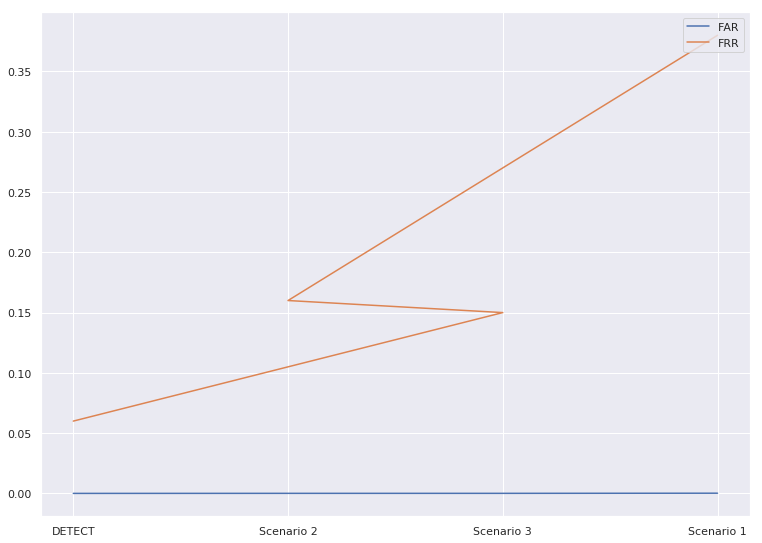

In [8]:
far_mean = far_data.groupby('Step').mean().sort_values(by=['False Positive Rate (FAR)'], ascending=True)
frr_mean = frr_data.groupby('Step').mean().sort_values(by=['False Negative Rate (FRR)'], ascending=True)

frr_mean = frr_mean.round(2)

plt.plot(far_mean, label='FAR')
plt.plot(frr_mean, label='FRR')
plt.legend(loc="upper right")

## Precision histogram

In [9]:
def set_shared_ylabel(axes, ylabel, labelpad = 0.01):
    """Set a y label shared by multiple axes
    Parameters
    ----------
    a: list of axes
    ylabel: string
    labelpad: float
        Sets the padding between ticklabels and axis label"""

    f = axes[0].get_figure()
    f.canvas.draw() #sets f.canvas.renderer needed below

    # get the center position for all plots
    top = axes[0].get_position().y1
    bottom = axes[-1].get_position().y0

    # get the coordinates of the left side of the tick labels 
    x0 = 1
    for ax in axes:
        ax.set_ylabel('') # just to make sure we don't and up with multiple labels
        bboxes, _ = ax.yaxis.get_ticklabel_extents(f.canvas.renderer)
        bboxes = bboxes.inverse_transformed(f.transFigure)
        xt = bboxes.x0
        if xt < x0:
            x0 = xt
    tick_label_left = x0

    # set position of label
    axes[-1].set_ylabel(ylabel, fontsize=22)
    axes[-1].yaxis.set_label_coords(tick_label_left - labelpad, (bottom + top)/2, transform=f.transFigure)

In [10]:
def filter_results(classification_report_filename):
    """ Remove the last three rows of a classification report
        where there are the accuracy, macro avg and
        weighted avg values
    """
    results = pd.read_csv(classification_report_filename)
    results.rename(columns={"Unnamed: 0": "person"}, inplace=True)

    accuracy = results[results['person'] == 'accuracy']
    macro_avg = results[results['person'] == 'macro avg']
    weighted_avg = results[results['person'] == 'weighted avg']

    results.drop(results.tail(3).index,inplace=True)

    return results, accuracy, macro_avg, weighted_avg

In [11]:
classification_report_step_1, accuracy_step_1, macro_avg_step_1, weighted_avg_step_1 = filter_results('classification_report_1.csv')
classification_report_step_2, accuracy_step_2, macro_avg_step_2, weighted_avg_step_2 = filter_results('classification_report_2.csv')
classification_report_step_3, accuracy_step_3, macro_avg_step_3, weighted_avg_step_3 = filter_results('classification_report_3.csv')
classification_report_step_4, accuracy_step_4, macro_avg_step_4, weighted_avg_step_4 = filter_results('classification_report_4.csv')

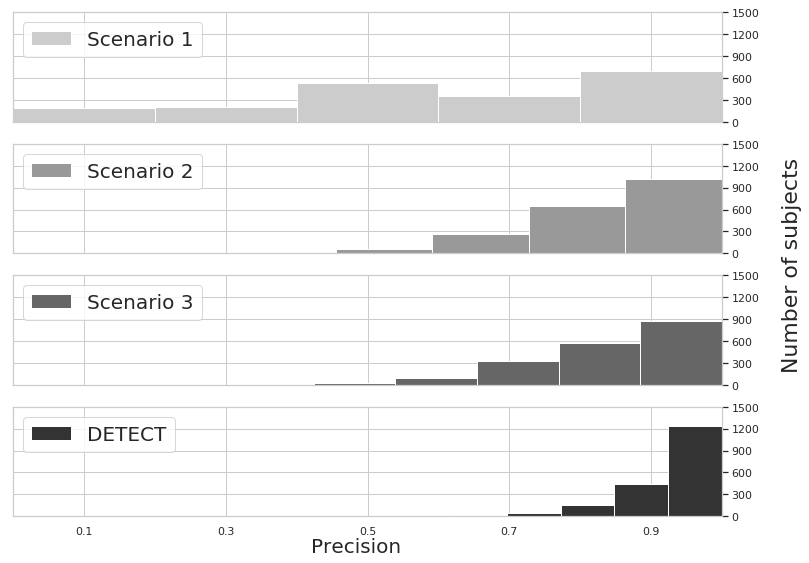

In [21]:
sns.set(rc={'figure.figsize':(12.7,9.27)})
sns.set_style("whitegrid")
sharex='col'
n_plots = 4
f, axes = plt.subplots(n_plots, 1, sharex=True, sharey=True)
plt.xlim(0, 1)
metric= 'precision'
bins=5
kde = False
aplha = 1
y_lower_lim = 0
y_upper_lim = 1500

#f.suptitle(f'{metric} histogram', fontsize=17)
set_shared_ylabel(axes, 'Number of subjects', labelpad=-0.90)
plt.xticks(labels=None)
# shared x label 
f.text(0.5, 0.08, 'Precision', ha='center', va='center', fontsize=20)

# first distplot blue
sns.distplot(classification_report_step_1[metric], bins=bins, kde=kde,
             ax=axes[0], color="#cccccc",
             label="Scenario 1",
             hist_kws={"alpha":aplha})
axes[0].legend(loc="upper left", prop={'size': 20})
axes[0].set_ylim(y_lower_lim,y_upper_lim)
axes[0].set_xlabel(None)
axes[0].yaxis.tick_right()

# second distpot olive
sns.distplot(classification_report_step_2[metric], bins=bins, kde=kde,
             ax=axes[1], color="#999999",
             label="Scenario 2",
             hist_kws={"alpha":aplha})
axes[1].legend(loc="upper left", prop={'size': 20})
axes[1].set_ylim(y_lower_lim,y_upper_lim)
axes[1].set_xlabel(None)
axes[1].yaxis.tick_right()

# third distplot red
sns.distplot(classification_report_step_3[metric], bins=bins, kde=kde,
             ax=axes[2], color="#666666",
             label="Scenario 3",
             hist_kws={"alpha":aplha})
axes[2].legend(loc="upper left", prop={'size': 20})
axes[2].set_ylim(y_lower_lim,y_upper_lim)
axes[2].set_xlabel(None)
axes[2].yaxis.tick_right()

# fourth distplot purple
sns.distplot(classification_report_step_4[metric], bins=bins, kde=kde,
             ax=axes[3], color="#333333",
             label="DETECT",
             hist_kws={"alpha":aplha})
axes[3].legend(loc="upper left", prop={'size': 20})
axes[3].set_ylim(y_lower_lim,y_upper_lim)
axes[3].set_xlabel(None)
axes[3].set_yticks(np.arange(0, 1800, step=300))
axes[3].set_xticks(np.arange(0.1, 1.1, step=0.2))
axes[3].yaxis.tick_right()


plt.savefig("precision_distribution.eps")
#files.download("precision_histogram.eps")

In [13]:
 #unifica os resultados dos 4 testes em um dataframe unico
list_of_results = [classification_report_step_1.mean(), classification_report_step_2.mean(), classification_report_step_3.mean(), classification_report_step_4.mean()]
df = pd.DataFrame(list_of_results)
df['step'] = ['Step 1','Step 2','Step 3','DETECT']
df.drop(['support'],  axis=1, inplace=True)
df

,precision,recall,f1-score,step
0,0.634018,0.616187,0.596146,Step 1
1,0.849373,0.843041,0.841537,Step 2
2,0.854982,0.846199,0.845042,Step 3
3,0.940212,0.935997,0.936095,DETECT


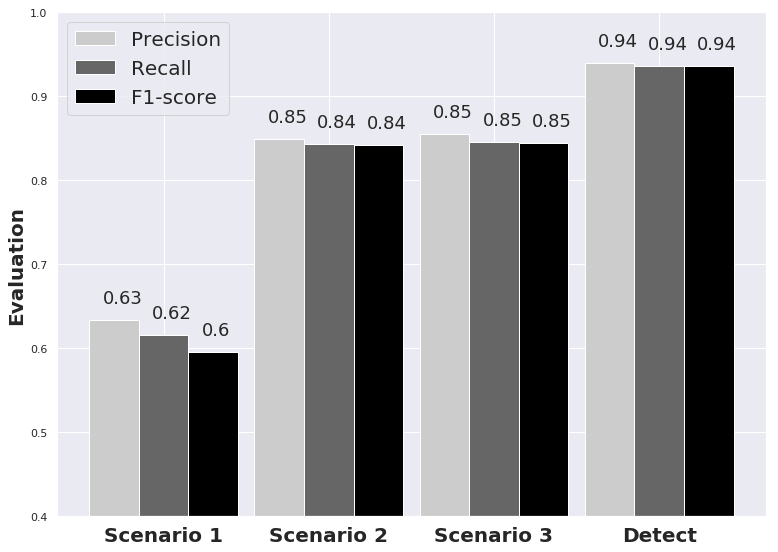

In [14]:
sns.set(rc={'figure.figsize':(12.7,9.27)})
# set width of bar
barWidth = 0.3

# Set position of bar on X axis
r1 = np.arange(len(df['precision']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# posiiton bar value a little above the bar itself
y_offset = 0.02
# Precision
plt.bar(r1, df['precision'], color='#cccccc', width=barWidth,
        edgecolor='white', label='Precision')

for i, value in enumerate(df['precision']):
    plt.text(i-0.07, value+y_offset, str(round(value,2)), fontsize=18)

# Recall
plt.bar(r2, df['recall'], color='#666666', width=barWidth, 
        edgecolor='white', label='Recall')

for i, value in enumerate(df['recall']):
    plt.text(i-0.07+barWidth, value+y_offset, str(round(value,2)), fontsize=18)

# F1-Score
plt.bar(r3, df['f1-score'], color='#000000', 
        width=barWidth, edgecolor='white', label='F1-score')
 
for i, value in enumerate(df['f1-score']):
    plt.text(i-0.07+barWidth*2, value+y_offset, str(round(value,2)), fontsize=18)
    
# Add xticks on the middle of the group bars
plt.ylabel('Evaluation', fontweight='bold', fontsize=20)
plt.xticks([r + barWidth for r in range(len(df['precision']))],
           ['Scenario 1','Scenario 2','Scenario 3','Detect'],
           fontweight='bold', fontsize=20)
plt.ylim(0.4,1)
 
# Create legend & Show graphic
plt.legend(loc="upper left", prop={'size': 20})

plt.savefig("classical_metrics.eps")
#files.download("increased_signal_version_2.eps")

In [15]:
def get_roc_auc_score(y_test, probabilities):
    '''
        Calculate 4 different averages for the roc auc score
    '''
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
    
    roc_auc = {}
    roc_auc['OVR Macro Average'] = roc_auc_score(y_test, probabilities, 
                                      multi_class="ovr", average="macro")
    roc_auc['OVR Weighted Average'] = roc_auc_score(y_test, probabilities, 
                                         multi_class="ovr", average="weighted")
    roc_auc['OVR Micro Average'] = roc_auc_score(y_test, probabilities, 
                                      multi_class="ovr", average="micro")
    roc_auc['OVR Samples Average'] = roc_auc_score(y_test, probabilities, 
                                         multi_class="ovr", average="samples")

    return roc_auc

In [16]:
# save roc auc scores
roc_auc_step_1 = get_roc_auc_score(y_test_step_1, probabilities_step_1)
roc_auc_step_2 = get_roc_auc_score(y_test_step_2, probabilities_step_2)
roc_auc_step_3 = get_roc_auc_score(y_test_step_3, probabilities_step_3)
roc_auc_step_4 = get_roc_auc_score(y_test_step_4, probabilities_step_4)

# make a dataframe containing roc_auc_scores from all 4 steps
index = ['Step 1', 'Step 2', 'Step 3', 'DETECT']
roc_auc_scores_df = pd.Dataframe([roc_auc_step_1, roc_auc_step_2, roc_auc_step_3, roc_auc_step_4], index=index)

NameError: name 'y_test_step_1' is not defined

In [ ]:
#plot roc_auc_score here